In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

from models.model_torch import create_model
from data.loader_torch import JetDataset, load_split_from_csv

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import json
import pandas as pd


In [11]:
# === CONFIG ===
model_tag = "EfficientNet"
backbone = 'efficientnet'
batch_size = 512
epochs = 50
learning_rate = 1e-4
global_max = 121.79151153564453
output_dir = 'training_output/'

In [12]:
import platform
import os
import re

# === Determine platform-specific base path ===
system = platform.system()
hostname = os.uname().nodename.lower()

if system == "Linux" and "wsl" in platform.release().lower():
    base_path = "/mnt/d/Projects/110_JetscapeML/hm_jetscapeml_source/data"
    print("[INFO] Running on WSL")
elif "hm-srv2" in hostname or "arsalan" in hostname:
    base_path = "/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data"
    print("[INFO] Running on Ubuntu")
else:
    raise RuntimeError("❌ Unknown system. Please define the dataset path for this host.")

# === Define dataset subdirectory (only this part changes per dataset) ===
dataset_subdir = "jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled"

# === Full dataset path ===
dataset_root_dir = os.path.join(base_path, dataset_subdir)
print(f"[INFO] Using dataset root: {dataset_root_dir}")

# === Extract dataset size from path ===
match = re.search(r"size_(\d+)", dataset_root_dir)
dataset_size = match.group(1) if match else "unknown"
print(f"[INFO] Detected dataset size: {dataset_size}")


[INFO] Running on WSL
[INFO] Using dataset root: /mnt/d/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled
[INFO] Detected dataset size: 1000


In [13]:
# Build dynamic output directory
run_tag = f"{model_tag}_bs{batch_size}_ep{epochs}_lr{learning_rate:.0e}_ds{dataset_size}"
output_dir = os.path.join(output_dir, run_tag)

os.makedirs(output_dir, exist_ok=True)
print(f"[INFO] Saving all outputs to: {output_dir}")

train_csv = os.path.join(dataset_root_dir, 'train_files.csv')
val_csv = os.path.join(dataset_root_dir, 'val_files.csv')

[INFO] Saving all outputs to: training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000


In [14]:

# Load splits from CSV
train_list = load_split_from_csv(train_csv, dataset_root_dir)
val_list = load_split_from_csv(val_csv, dataset_root_dir)

train_dataset = JetDataset(train_list, global_max=global_max)
val_dataset = JetDataset(val_list, global_max=global_max)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"[INFO] Training samples: {len(train_dataset)}")
print(f"[INFO] Validation samples: {len(val_dataset)}")

#show the length of the dataloaders
print(f"[INFO] Length of training dataloader: {len(train_loader)}")
print(f"[INFO] Length of validation dataloader: {len(val_loader)}")



[INFO] Training samples: 796
[INFO] Validation samples: 96
[INFO] Length of training dataloader: 2
[INFO] Length of validation dataloader: 1


In [15]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

model, optimizer = create_model(backbone=backbone, input_shape=(1, 32, 32), learning_rate=learning_rate)
model = model.to(device)

criterion = {
    'energy_loss_output': nn.BCELoss(),
    'alpha_output': nn.CrossEntropyLoss(),
    'q0_output': nn.CrossEntropyLoss()
}
print(criterion)


[INFO] Using device: cuda
{'energy_loss_output': BCELoss(), 'alpha_output': CrossEntropyLoss(), 'q0_output': CrossEntropyLoss()}


In [16]:

def train_one_epoch(loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for x, labels in tqdm(loader, desc="Training", leave=False):
        x = x.to(device)
        for key in labels:
            labels[key] = labels[key].to(device)

        outputs = model(x)
        loss = (
            criterion['energy_loss_output'](outputs['energy_loss_output'].squeeze(), labels['energy_loss_output'].float().squeeze()) +
            criterion['alpha_output'](outputs['alpha_output'], labels['alpha_output'].squeeze()) +
            criterion['q0_output'](outputs['q0_output'], labels['q0_output'].squeeze())
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    return running_loss / len(loader)

def evaluate(loader, model, device):
    model.eval()
    y_true = {'energy': [], 'alpha': [], 'q0': []}
    y_pred = {'energy': [], 'alpha': [], 'q0': []}
    correct_all = 0
    total = 0

    with torch.no_grad():
        for x, labels in loader:
            x = x.to(device)
            for key in labels:
                labels[key] = labels[key].to(device)

            outputs = model(x)

            # Energy loss: binary thresholding
            pred_energy = (outputs['energy_loss_output'] > 0.5).long().squeeze()
            pred_alpha = torch.argmax(outputs['alpha_output'], dim=1)
            pred_q0 = torch.argmax(outputs['q0_output'], dim=1)

            gt_energy = labels['energy_loss_output'].squeeze()
            gt_alpha = labels['alpha_output'].squeeze()
            gt_q0 = labels['q0_output'].squeeze()

            y_true['energy'].extend(labels['energy_loss_output'].squeeze().cpu().numpy())
            y_true['alpha'].extend(labels['alpha_output'].squeeze().cpu().numpy())
            y_true['q0'].extend(labels['q0_output'].squeeze().cpu().numpy())

            y_pred['energy'].extend(pred_energy.cpu().numpy())
            y_pred['alpha'].extend(pred_alpha.cpu().numpy())
            y_pred['q0'].extend(pred_q0.cpu().numpy())

            # Total accuracy = all 3 correct
            correct_batch = ((pred_energy == gt_energy) &
                             (pred_alpha == gt_alpha) &
                             (pred_q0 == gt_q0)).sum().item()
            correct_all += correct_batch
            total += x.size(0)
    # Compute individual accuracies
    acc_total = correct_all / total

    metrics = {}
    for task in ['energy', 'alpha', 'q0']:
        metrics[task] = {
            'accuracy': accuracy_score(y_true[task], y_pred[task]),
            'precision': precision_score(y_true[task], y_pred[task], average='macro'),
            'recall': recall_score(y_true[task], y_pred[task], average='macro'),
            'f1': f1_score(y_true[task], y_pred[task], average='macro')
        }

    return metrics, acc_total


In [17]:
train_losses = []
val_losses = []

val_accs = []

acc_energy_list = []
acc_alpha_list = []
acc_q0_list = []
acc_total_list = []

all_epoch_metrics = []

In [18]:
import json
import datetime, json

summary_path = os.path.join(output_dir, "training_summary.json")
resume_path = os.path.join(output_dir, "best_model.pth")
best_model_path = os.path.join(output_dir, f"best_model.pth")

patience = 5
best_epoch = 0
start_epoch = 0
best_total_acc = 0.0
early_stop_counter = 0

best_metrics = {}
training_summary= {}

# Try loading resume state
if os.path.exists(resume_path) and os.path.exists(summary_path):
    print(f"🔁 Resuming training from checkpoint and summary")
    
    # Load model checkpoint
    checkpoint = torch.load(resume_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_total_acc = checkpoint.get('acc_total', 0.0)
    best_metrics = checkpoint.get('metrics', {})

    # Load summary info (optional counters/history)
    with open(summary_path, "r") as f:
        summary_data = json.load(f)
        early_stop_counter = summary_data.get("early_stop_counter", 0)
        acc_energy_list = summary_data.get("acc_energy_list", [])
        acc_alpha_list = summary_data.get("acc_alpha_list", [])
        acc_q0_list = summary_data.get("acc_q0_list", [])
        acc_total_list = summary_data.get("acc_total_list", [])
        all_epoch_metrics = summary_data.get("all_epoch_metrics", [])

    print(f"[INFO] Resumed at epoch {start_epoch} with total acc {best_total_acc:.4f} and early stop counter {early_stop_counter}")
else:
    print(f"[INFO] Starting fresh training run")
    
    # Initial summary structure
    training_summary = {
        "model_tag": model_tag,
        "backbone": backbone,
        "batch_size": batch_size,
        "epochs": epochs,
        "learning_rate": learning_rate,
        "dataset_root": dataset_root_dir,
        "global_max": global_max,
        "start_time": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "status": "interrupted_or_incomplete"
    }

    # Save the early config snapshot
    summary_path = os.path.join(output_dir, "training_summary.json")
    with open(summary_path, "w") as f:
        json.dump(training_summary, f, indent=2)

    print(f"[INFO] Initial training summary saved at: {summary_path}")
    
    # acc_energy_list, acc_alpha_list, acc_q0_list, acc_total_list = [], [], [], []
    # all_epoch_metrics = []


🔁 Resuming training from checkpoint and summary


/tmp/ipykernel_10677/2170570611.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(resume_path, map_location=device)


[INFO] Resumed at epoch 1 with total acc 0.0833 and early stop counter 0


In [19]:

for epoch in range(start_epoch, epochs):
    train_loss = train_one_epoch(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}")

    metrics, acc_total = evaluate(val_loader, model, device)

    acc_energy_list.append(metrics['energy']['accuracy'])
    acc_alpha_list.append(metrics['alpha']['accuracy'])
    acc_q0_list.append(metrics['q0']['accuracy'])
    acc_total_list.append(acc_total)
    
    import datetime
    print("="*epochs)
    # print(f"Epoch {epoch+1}: αs Acc = {acc_alpha:.4f}, Q0 Acc = {acc_q0:.4f}, Total Acc = {acc_total:.4f}")
    if acc_total > best_total_acc:
        best_total_acc = acc_total
        best_metrics = metrics
        best_epoch = epoch + 1
        early_stop_counter = 0  # reset counter

        # Save best model
        best_model_path = os.path.join(output_dir, "best_model.pth")
        torch.save({
            'epoch': best_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'metrics': best_metrics,
            'acc_total': acc_total,
            'backbone': backbone,
            'input_shape': (1, 32, 32),
        }, best_model_path)

        print(f"✅ Best model saved at epoch {best_epoch} with total accuracy: {acc_total:.4f}")
    else:
        early_stop_counter += 1
        print(f"⏳ No improvement. Early stop counter: {early_stop_counter}/{patience}")

        if early_stop_counter >= patience:
            print(f"🛑 Early stopping triggered at epoch {epoch+1}. Best was at epoch {best_epoch}.")
            break
        
    print(f"✅ Best model saved with total accuracy: {acc_total:.4f}")
    print(f"[{datetime.datetime.now().strftime('%H:%M:%S')}] Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}")
    epoch_record = {
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'total_accuracy': acc_total,
        'energy': metrics['energy'],
        'alpha': metrics['alpha'],
        'q0': metrics['q0']
    }
    all_epoch_metrics.append(epoch_record)
    
    with open(os.path.join(output_dir, "epoch_metrics.json"), "w") as f:
        json.dump(all_epoch_metrics, f, indent=2)
    

    df = pd.DataFrame([
        {
            'epoch': m['epoch'],
            'train_loss': m['train_loss'],
            'total_acc': m['total_accuracy'],
            'energy_acc': m['energy']['accuracy'],
            'energy_prec': m['energy']['precision'],
            'energy_rec': m['energy']['recall'],
            'energy_f1': m['energy']['f1'],
            'alpha_acc': m['alpha']['accuracy'],
            'alpha_prec': m['alpha']['precision'],
            'alpha_rec': m['alpha']['recall'],
            'alpha_f1': m['alpha']['f1'],
            'q0_acc': m['q0']['accuracy'],
            'q0_prec': m['q0']['precision'],
            'q0_rec': m['q0']['recall'],
            'q0_f1': m['q0']['f1'],
        }
        for m in all_epoch_metrics
    ])
    df.to_csv(os.path.join(output_dir, "epoch_metrics.csv"), index=False)

    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'acc_total': acc_total,
        'metrics': metrics,
    }, os.path.join(output_dir, f"checkpoint_epoch_{epoch+1}.pth"))

Epoch 2/50 - Train Loss: 3.1668


/home/arsi/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsi/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsi/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

⏳ No improvement. Early stop counter: 1/5
✅ Best model saved with total accuracy: 0.0833
[16:45:21] Epoch 2/50 - Train Loss: 3.1668


Epoch 3/50 - Train Loss: 3.1551


/home/arsi/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsi/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsi/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

⏳ No improvement. Early stop counter: 2/5
✅ Best model saved with total accuracy: 0.0833
[16:45:27] Epoch 3/50 - Train Loss: 3.1551


Epoch 4/50 - Train Loss: 3.1420


/home/arsi/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsi/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsi/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

⏳ No improvement. Early stop counter: 3/5
✅ Best model saved with total accuracy: 0.0833
[16:45:33] Epoch 4/50 - Train Loss: 3.1420


Epoch 5/50 - Train Loss: 3.1185


/home/arsi/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsi/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsi/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

⏳ No improvement. Early stop counter: 4/5
✅ Best model saved with total accuracy: 0.0833
[16:45:39] Epoch 5/50 - Train Loss: 3.1185


Epoch 6/50 - Train Loss: 3.1051
⏳ No improvement. Early stop counter: 5/5
🛑 Early stopping triggered at epoch 6. Best was at epoch 0.


/home/arsi/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsi/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arsi/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [20]:
# Update and finalize the training summary
training_summary.update({
    "best_epoch": best_epoch,
    "best_total_accuracy": best_total_acc,
    "end_time": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "status": "completed",
    "best_model_path": os.path.abspath(os.path.join(output_dir, "best_model.pth")),
    "metrics_file": os.path.abspath(os.path.join(output_dir, "best_model_metrics.json")),
    "epoch_metrics_csv": os.path.abspath(os.path.join(output_dir, "epoch_metrics.csv")),
    "epoch_metrics_json": os.path.abspath(os.path.join(output_dir, "epoch_metrics.json"))
})

# Overwrite with final summary
with open(summary_path, "w") as f:
    json.dump(training_summary, f, indent=2)

print(f"✅ Final training summary updated and saved to: {summary_path}")

✅ Final training summary updated and saved to: training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/training_summary.json


In [21]:
print(f"\n🏁 Best Model @ Epoch {best_epoch}")
print(f"Total Accuracy: {best_total_acc:.4f}")
for task in ['energy', 'alpha', 'q0']:
    print(f"\n🔹 {task.upper()} Task")
    print(f"  Accuracy : {best_metrics[task]['accuracy']:.4f}")
    print(f"  Precision: {best_metrics[task]['precision']:.4f}")
    print(f"  Recall   : {best_metrics[task]['recall']:.4f}")
    print(f"  F1-Score : {best_metrics[task]['f1']:.4f}")
print(f"Saved to: {best_model_path}")


🏁 Best Model @ Epoch 0
Total Accuracy: 0.0833

🔹 ENERGY Task
  Accuracy : 0.7500
  Precision: 0.3750
  Recall   : 0.5000
  F1-Score : 0.4286

🔹 ALPHA Task
  Accuracy : 0.3333
  Precision: 0.1111
  Recall   : 0.3333
  F1-Score : 0.1667

🔹 Q0 Task
  Accuracy : 0.2500
  Precision: 0.0625
  Recall   : 0.2500
  F1-Score : 0.1000
Saved to: training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/best_model.pth


📉 Loss plot saved as:
  - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/loss_plot.png
  - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/loss_plot.pdf


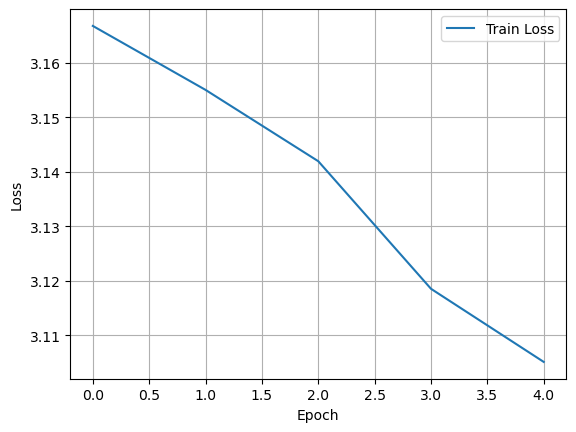

In [22]:
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Save loss plot
loss_path_png = os.path.join(output_dir, "loss_plot.png")
loss_path_pdf = os.path.join(output_dir, "loss_plot.pdf")

plt.savefig(loss_path_png, dpi=300, bbox_inches='tight')
plt.savefig(loss_path_pdf, bbox_inches='tight')

print(f"📉 Loss plot saved as:\n  - {loss_path_png}\n  - {loss_path_pdf}")

plt.show()

📊 Validation accuracy plot saved as:
  - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/val_accuracy_plot.png
  - training_output/EfficientNet_bs512_ep50_lr1e-04_ds1000/val_accuracy_plot.pdf


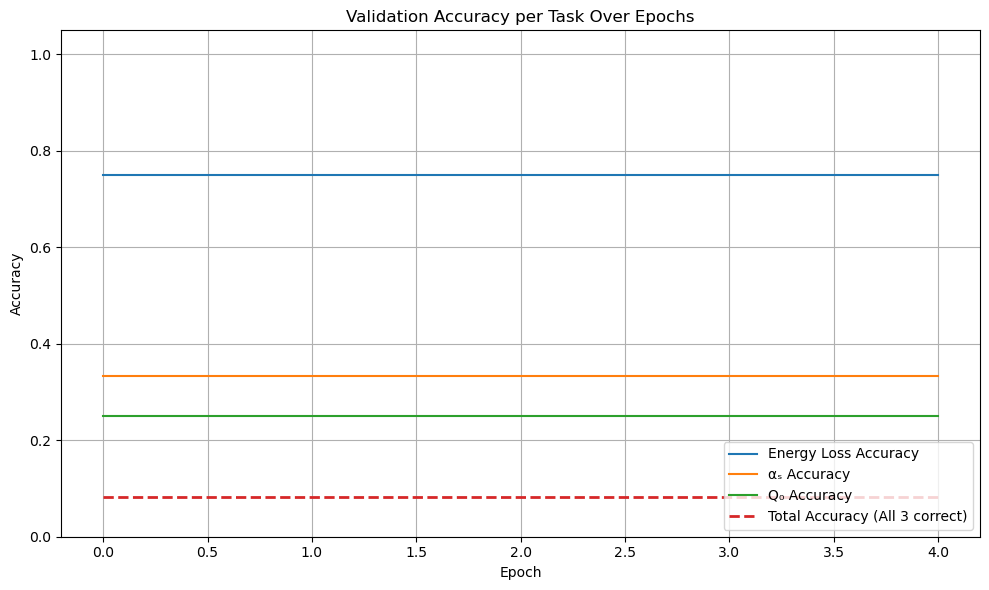

In [24]:
plt.figure(figsize=(10, 6))

plt.plot(acc_energy_list, label='Energy Loss Accuracy')
plt.plot(acc_alpha_list, label='αₛ Accuracy')
plt.plot(acc_q0_list, label='Q₀ Accuracy')
plt.plot(acc_total_list, label='Total Accuracy (All 3 correct)', linestyle='--', linewidth=2)

plt.title("Validation Accuracy per Task Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()

# Save accuracy plot
fig_path_png = os.path.join(output_dir, "val_accuracy_plot.png")
fig_path_pdf = os.path.join(output_dir, "val_accuracy_plot.pdf")

plt.savefig(fig_path_png, dpi=300, bbox_inches='tight')
plt.savefig(fig_path_pdf, bbox_inches='tight')

print(f"📊 Validation accuracy plot saved as:\n  - {fig_path_png}\n  - {fig_path_pdf}")

plt.show()

In [25]:
import torch
from models.model_torch import create_model

# Load checkpoint
checkpoint = torch.load(best_model_path
, map_location=torch.device('cpu'))

# Recreate model using saved params
model, _ = create_model(
    backbone=checkpoint['backbone'],
    input_shape=checkpoint['input_shape'],
    learning_rate=1e-4  # not used when reloading
)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Model loaded from epoch {checkpoint['epoch']} with Total Accuracy: {checkpoint['acc_total']:.4f}")


✅ Model loaded from epoch 1 with Total Accuracy: 0.0833


/tmp/ipykernel_10677/98680750.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path


In [26]:
import json
with open(os.path.join(output_dir, "best_model_metrics.json")
, "w") as f:
    json.dump(checkpoint['metrics'], f, indent=2)